In [1]:
# Model 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("dataset.csv")
df.head()

Saving dataset.csv to dataset (1).csv


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [4]:
# Convert time columns to a single datetime column for better management
df["Timestamp"] = pd.to_datetime(df["LastUpdatedDate"] + " " + df["LastUpdatedTime"], format= '%d-%m-%Y %H:%M:%S')

# Sort data chronologically
df.sort_values(by=["SystemCodeNumber", "Timestamp"], inplace=True)

df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00


In [5]:
# Initialize base price and α
BASE_PRICE = 10
ALPHA = 2.0  # price sensitivity factor
MIN_PRICE = 0.5 * BASE_PRICE
MAX_PRICE = 2.0 * BASE_PRICE

# Apply the pricing model groupwise for each parking lot
df["Price"] = np.nan

In [6]:
# A function to calculate new price based on occupancy within the bounds
def compute_price(prev_price, occupancy, capacity, alpha=ALPHA):
    delta = alpha * (occupancy / capacity)
    new_price = prev_price + delta
    return max(MIN_PRICE, min(MAX_PRICE, new_price))

In [8]:
# Group by parking lot starting with the base price
for lot_id, group in df.groupby("SystemCodeNumber"):
    group = group.sort_values("Timestamp")
    prices = [BASE_PRICE]

    for i in range(1, len(group)):
        prev_price = prices[-1]
        occupancy = group.iloc[i]["Occupancy"]
        capacity = group.iloc[i]["Capacity"]
        new_price = compute_price(prev_price, occupancy, capacity)
        prices.append(new_price)

    df.loc[group.index, "Price"] = prices

# Final dataframe has updated prices
print(df[["SystemCodeNumber", "Timestamp", "Occupancy", "Capacity", "Price"]].head(10))

  SystemCodeNumber           Timestamp  Occupancy  Capacity      Price
0      BHMBCCMKT01 2016-10-04 07:59:00         61       577  10.000000
1      BHMBCCMKT01 2016-10-04 08:25:00         64       577  10.221837
2      BHMBCCMKT01 2016-10-04 08:59:00         80       577  10.499133
3      BHMBCCMKT01 2016-10-04 09:32:00        107       577  10.870017
4      BHMBCCMKT01 2016-10-04 09:59:00        150       577  11.389948
5      BHMBCCMKT01 2016-10-04 10:26:00        177       577  12.003466
6      BHMBCCMKT01 2016-10-04 10:59:00        219       577  12.762565
7      BHMBCCMKT01 2016-10-04 11:25:00        247       577  13.618718
8      BHMBCCMKT01 2016-10-04 11:59:00        259       577  14.516464
9      BHMBCCMKT01 2016-10-04 12:29:00        266       577  15.438475


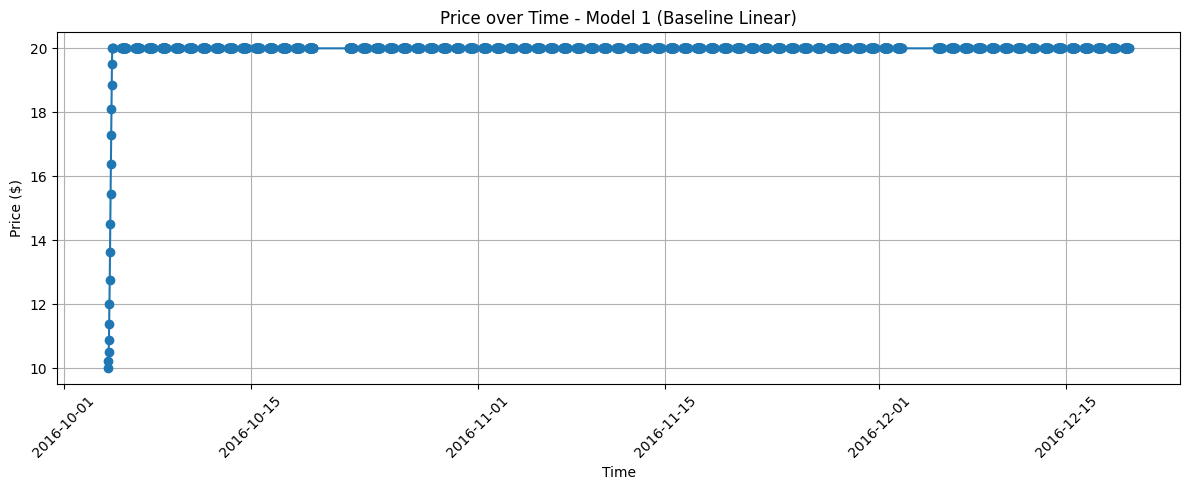

In [9]:
# Plotting price over time for a sample lot
sample_lot = df[df["SystemCodeNumber"] == df["SystemCodeNumber"].iloc[0]]
plt.figure(figsize=(12, 5))
plt.plot(sample_lot["Timestamp"], sample_lot["Price"], marker='o')
plt.title("Price over Time - Model 1 (Baseline Linear)")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()